In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm as tqdm_notebook

### Задача 1. CUPED (2.5 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [ ]:
control_before = stats.expon(scale=1000).rvs(1000)

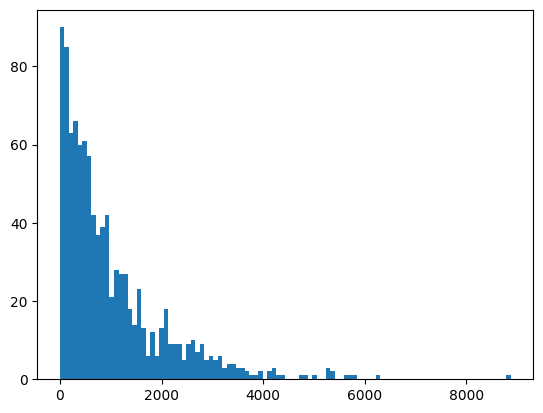

In [ ]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [ ]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

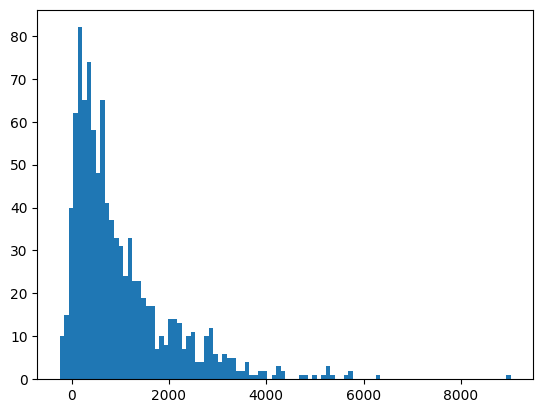

In [ ]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [ ]:
# смотрю, что в оригинале

control_before = stats.expon(scale=1000).rvs(1000)
stats.norm(loc=control_before.mean(), scale=control_before.std() / np.sqrt(len(control_before))).ppf(
    [0.025, 0.975]
)

array([ 909.23494658, 1028.3620025 ])

In [ ]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 946.59087829, 1071.41789859])

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в 5.24% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

$$w = \frac{\text{cov}(X, Y)}{\text{var}(Y)},$$

где X --- до эксперимента, Y --- после.

$${X}_{cuped} = {X} - w {Y} + w \text{E}(Y)$$

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    w = np.cov(control, control_before)[0, 1] / np.var(control_before)
    cuped = control - w * control_before + w * np.mean(control_before)

    mean = np.mean(cuped)
    std = np.std(cuped) / np.sqrt(len(cuped))

    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  84.89% случаев;


Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [ ]:
bad_cnt = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )

    control_before_ab = np.concatenate([control_before_a, control_before_b])
    control_after_ab = np.concatenate([control_after_a, control_after_b])
    w = np.cov(control_after_ab, control_before_ab)[0, 1] / np.var(control_before_ab)

    control_cup_a = control_after_a - w * control_before_a + w * control_before_full.mean()
    control_cup_b = control_after_b - w * control_before_b + w * control_before_full.mean()

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  5.36% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



**Мои мысли:** В первом случае мы сравнивали группу и группу с шумом, а во втором --- две разные подгруппы + шум, то есть, казалось бы, эти подгруппы должны быть как раз более разные. Но в первом случае наш тест сильно реагировал на шум, а во втором -- метрика CUPED позволяет уменьшить смещение (в нашем случае --- смещение из-за шума, т.к. данные изначально из одного распределения) и поэтому не отвлекаться на шум. Поэтому и результат получился более, чем удовлетворительный, и наш тест сработал хорошо.

Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [ ]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in tqdm_notebook(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )

    control_before_ab = np.concatenate([control_before_a, control_before_b])
    control_after_ab = np.concatenate([control_after_a, control_after_b])
    w = np.cov(control_after_ab, control_before_ab)[0, 1] / np.var(control_before_ab)

    control_cup_a = control_after_a - w * control_before_a + w * control_before_full.mean()
    control_cup_b = control_after_b - w * control_before_b + w * control_before_full.mean()

    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев"
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Стат значимая разница есть в  5.4399999999999995% случаев; при использовании CUPED -- в 47.199999999999996% случаев


### Задача 2. Методы снижения дисперсии (2.5 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи:
- `None` - пользователь не участвует в АБ тесте,
- `*_before_i` - соответствующая группа до начала теста,
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение.

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Задание
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED.

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [ ]:
data = pd.read_csv("data_ab.csv")

In [ ]:
data.head()

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before


1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

In [ ]:
def my_ttest(a, b):
    mean_a, mean_b = np.mean(a), np.mean(b)
    var_a, var_b = np.var(a, ddof=1), np.var(b, ddof=1)

    t_statistics = (mean_a - mean_b) / np.sqrt((var_a / len(a)) + (var_b / len(b)))
    df = len(a) + len(b) - 2
    p_value = stats.t.sf(abs(t_statistics), df=df) *  2.0  # двухсторонний тест
    return p_value

2. Реализуйте пост-стратификацию и CUPED.

In [ ]:
def get_mean_var(group):
    grouped = group.groupby('age').metric
    mean = grouped.mean().values
    var = grouped.var().values
    part_weight = grouped.count().values / len(group)

    stratified_mean = np.sum(mean * part_weight)
    stratified_var = np.sum(var * part_weight)

    return stratified_mean, stratified_var

def stratified_ttest(treatment, control):
    t_stratified_mean, t_stratified_var = get_mean_var(treatment)
    c_stratified_mean, c_stratified_var = get_mean_var(control)

    t_stat = ((t_stratified_mean - c_stratified_mean) /
              np.sqrt((t_stratified_var / len(treatment)) + (c_stratified_var / len(control))))
    freedom_deg = len(treatment) + len(control) - 2
    p_value = stats.t.sf(abs(t_stat), df=freedom_deg) * 2

    return p_value

In [ ]:
def cuped_ttest(treatment_before_vals, control_before_vals, treatment_after_vals, control_after_vals, mean):
  w = np.cov(control_after_vals, control_before_vals)[0, 1] / np.var(control_before_vals)

  treatment_cuped = treatment_after_vals - w * treatment_before_vals + w * mean
  control_cuped = control_after_vals - w * control_before_vals + w * mean

  return my_ttest(treatment_cuped, control_cuped)

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

In [ ]:
# небольшая подготовительная работа

def group_i(group_i):
    return data.loc[data.group == group_i]

groups_num = 5

control_before = group_i('control_before')
treatment_before = group_i('treatment_before')
before_mean = np.concatenate([control_before.metric, treatment_before.metric]).mean()

compare_matrix = pd.DataFrame(
    index=['group_1', 'group_2', 'group_3', 'group_4', 'group_5'],
    columns=['Basic', 'Stratification', 'Cuped'],
)

compare_matrix['Basic'] = compare_matrix['Basic'].astype(float)
compare_matrix['Stratification'] = compare_matrix['Stratification'].astype(float)
compare_matrix['Cuped'] = compare_matrix['Cuped'].astype(float)

In [ ]:
for group_num in range(1, groups_num + 1):
    treatment_after_i = group_i(f'treatment_after_{group_num}')
    control_after_i = group_i(f'control_after_{group_num}')

    compare_matrix.loc[f'group_{group_num}', 'Basic'] = my_ttest(
        treatment_after_i['metric'].values, control_after_i['metric'].values)

    compare_matrix.loc[f'group_{group_num}', 'Stratification'] = stratified_ttest(
        treatment_after_i, control_after_i)

    compare_matrix.loc[f'group_{group_num}', 'Cuped'] = cuped_ttest(
        treatment_before['metric'].values, control_before['metric'].values,
        treatment_after_i['metric'].values, control_after_i['metric'].values,
        before_mean)

4. Опишите свои результаты.

In [ ]:
compare_matrix

,Basic,Stratification,Cuped
group_1,0.692247,0.342702,1.739100e-09
group_2,0.403349,0.046868,1.581297e-21
group_3,0.233666,0.004926,2.998111e-29
group_4,0.121493,0.000288,2.786905e-37
group_5,0.053815,0.000007,1.432468e-46


Все, как и написано в задании: без методов только в пятой группе pvalue около 0.05. Результаты говорят сами за себя: после применения методов снижения дисперсии мы получаем более эффективные результаты за тот же самый тест и можем точнее понять, есть ли отличия на нашем уровне значимости!

### Задача 3. Линеаризация + CUPED (2 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.

1. В файле duration_aa.csv содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

In [ ]:
data = pd.read_csv("duration_aa.csv")
data.head()

,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,JP1F82,first,ypn3ydiml32oelnslnjv,84.0
1,1,JP1F82,first,ypy93q2g8ypdtwbpv8b5,61.0
2,2,JP1F82,first,d8m6q0bmr40wgi6zuor3,81.0
3,3,JP1F82,first,5b72re4nr84fszqx7f6e,54.0
4,4,0Y2HSZ,first,z40pmuyaczi92gmlqz6t,97.0


In [ ]:
# предобработаем, чтобы воспользоваться кодом с семинара ^_^

def make_arrays(data):
  durations = dict()
  for _, note in data.iterrows():
    user_id = note[1]
    visit_duration = note[-1]

    if user_id in durations.keys():
      durations[user_id].append(visit_duration)
    else:
      durations[user_id] = [visit_duration]
  return durations

first = data[data.group == 'first']
durations_first = make_arrays(first).values()

second = data[data.group == 'second']
durations_second = make_arrays(second).values()

In [ ]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.

    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы

    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])  # суммарная длительность сессий для каждого клиента
    a_y = np.array([len(row) for row in a])  # количество сессий для каждого клиента

    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])

    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)

    delta_L = np.mean(b_lin) - np.mean(a_lin)  # разница линеаризованных метрик
    delta_R = np.sum(a_x) / np.sum(a_y) - np.sum(b_x) / np.sum(b_y)  # разница ratio-метрик
    return pvalue, delta_L, delta_R

In [ ]:
# технический код

def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

# не вышло придумать интеллектуальный способ

def choose_random_rows(data):
  res = []
  indexes = np.random.choice(len(data), size=500, replace=False)
  for i in indexes:
    res.append(data[i])
  return res

Приступим непосредственно к тестированию:

In [ ]:
pvalue, _, _ = check_linearization(list(durations_first), list(durations_second))
print('Разница значима:', pvalue < 0.05, '\npvalue:', pvalue)

Разница значима: False 
pvalue: 0.43727643231481905


Отлично -- в А/А-тесте получили, что средние групп похожи. Теперь построим распределение pvalue.

  0%|          | 0/1000 [00:00<?, ?it/s]

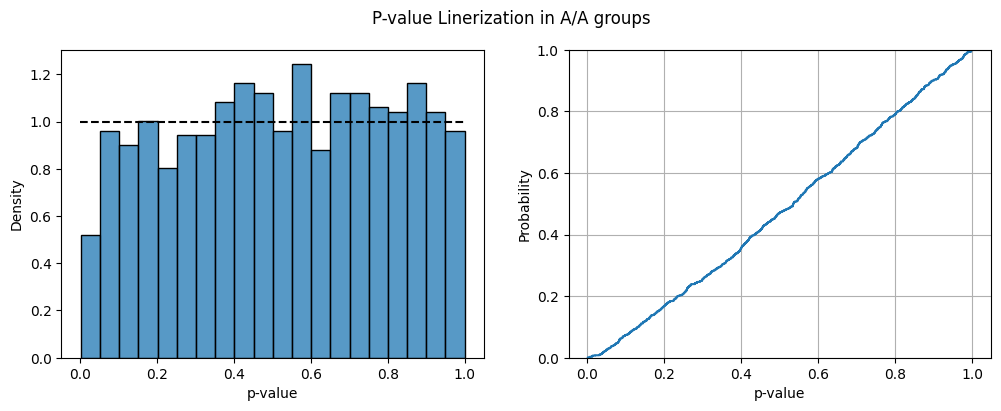

In [ ]:
list_pvalue = []
list_deltaL = []
list_deltaR = []

for _ in tqdm_notebook(range(1000)):
    a = choose_random_rows(list(durations_first))
    b = choose_random_rows(list(durations_second))

    pvalue, delta_L, delta_R = check_linearization(a, b)

    list_pvalue.append(pvalue)
    list_deltaL.append(delta_L)
    list_deltaR.append(delta_R)

plot_pvalue_ecdf(list_pvalue, title='P-value Linerization in A/A groups')

Покажем сонаправленность линеаризованной разности метрик и разности ratio-метрик, то есть что если наша метрика $R = \frac{\sum visit\_duration}{\sum visits\_count}$, линеаризованная $L$, то $L_T - L_C = mean\_visits\_count * (R_T - R_C)$.

Text(0, 0.5, '$\\Delta R$')

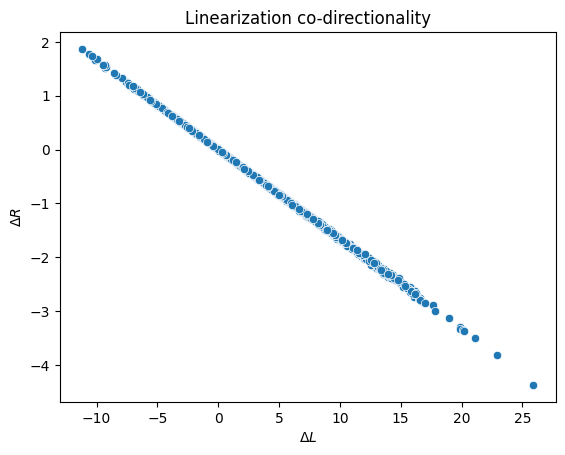

In [ ]:
sns.scatterplot(x=list_deltaL, y=list_deltaR)
plt.title('Linearization co-directionality')
plt.xlabel('$\Delta L$')
plt.ylabel('$\Delta R$')

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле duration_ab.csv. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

In [ ]:
data = pd.read_csv("duration_ab.csv")
data.head()

,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,AOXLT0,a,76v7fwlgmxa73cx08zvh,125.0
1,1,AOXLT0,a,dse16a8xow680xn4ly3o,115.0
2,2,AOXLT0,a,ei17obrkatjb0uglqglr,117.0
3,3,AOXLT0,a,cp9aczsn0zd8a7u9qoel,115.0
4,4,AOXLT0,a,t421ljy1eg7qpdx3dask,123.0


In [ ]:
# сделаем все то же самое

first = data[data.group == 'a']
durations_first = make_arrays(first).values()

second = data[data.group == 'b']
durations_second = make_arrays(second).values()

In [ ]:
pvalue, _, _ = check_linearization(list(durations_first), list(durations_second))
print('Разница значима:', pvalue < 0.05, '\npvalue:', pvalue)

Разница значима: False 
pvalue: 0.05695844605154051


Разницы нет, но pvalue очень близок к уровню значимости.

  0%|          | 0/1000 [00:00<?, ?it/s]

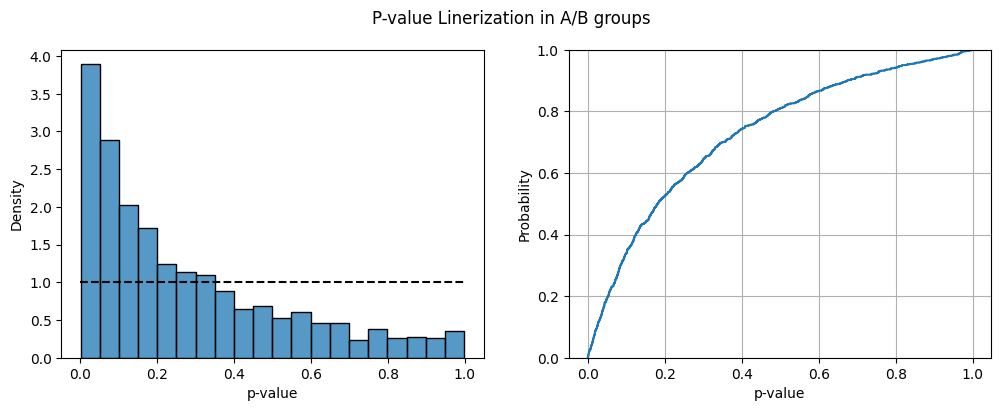

In [ ]:
list_pvalue = []
list_deltaL = []
list_deltaR = []

for _ in tqdm_notebook(range(1000)):
    a = choose_random_rows(list(durations_first))
    b = choose_random_rows(list(durations_second))

    pvalue, delta_L, delta_R = check_linearization(a, b)

    list_pvalue.append(pvalue)
    list_deltaL.append(delta_L)
    list_deltaR.append(delta_R)

plot_pvalue_ecdf(list_pvalue, title='P-value Linerization in A/B groups')

Покажем сонаправленность:

Text(0, 0.5, '$\\Delta R$')

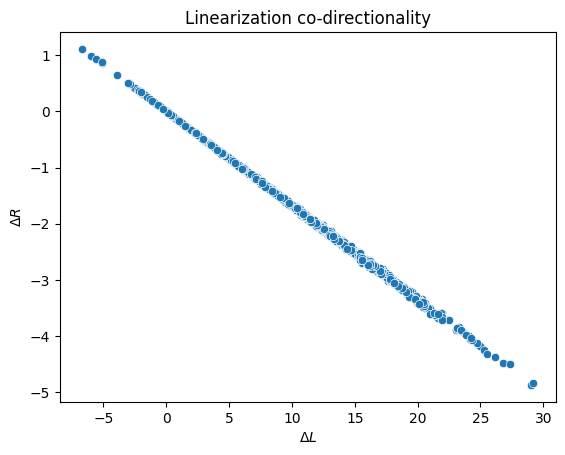

In [ ]:
sns.scatterplot(x=list_deltaL, y=list_deltaR)
plt.title('Linearization co-directionality')
plt.xlabel('$\Delta L$')
plt.ylabel('$\Delta R$')

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

In [ ]:
data = pd.read_csv("duration_hist.csv")
data.head()

,Unnamed: 0,user_id,visit_id,visit_duration
0,0,66U21N,2e9jn4qdjoot4vo9xn5g,76.0
1,1,MQE6TJ,v54g9sa6g6gcn6f7e3kk,97.0
2,2,X4A2B6,zmz8g1utfal68e1ctz8g,117.0
3,3,HFYD47,e8zvlx05icmrcn75ny5u,49.0
4,4,8C8XIX,886rt54buvgrtgah1i1f,83.0


In [ ]:
first_group = set(first.user_id)
second_group = set(second.user_id)

first_before = data[data.user_id.isin(first_group)]
second_before = data[data.user_id.isin(second_group)]

durations_firstbefore = make_arrays(first_before).values()
durations_secondbefore = make_arrays(second_before).values()

Поправим наши функции:

In [ ]:
def cuped_ttest(treatment_before_vals, control_before_vals, treatment_after_vals, control_after_vals, mean):
  w = np.cov(control_after_vals, control_before_vals)[0, 1] / np.var(control_before_vals)

  treatment_cuped = treatment_after_vals - w * treatment_before_vals + w * mean
  control_cuped = control_after_vals - w * control_before_vals + w * mean

  return my_ttest(treatment_cuped, control_cuped)

def linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.

    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы

    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])  # суммарная длительность сессий для каждого клиента
    a_y = np.array([len(row) for row in a])  # количество сессий для каждого клиента

    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])

    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y

    return a_lin, b_lin

def cuped_linearization(first_before, first_after, second_before, second_after):
    first_before_l, second_before_l = linearization(first_before, second_before)
    mean_before = np.append(first_before_l, second_before_l).mean()
    first_after_l, second_after_l = linearization(first_after, second_after)

    pvalue = cuped_ttest(second_before_l, first_before_l, second_after_l, first_after_l, mean_before)
    return pvalue

Еще пробовала небольшие танцы с бубном с коэффициентом линеаризации, чтобы проверить, лучше ли при линеаризации вычитать одно и то же среднее для групп до/после или разные (чтобы вычитать одно и то же, сохраняла коэффициент при первом подсчете). Получилось, что одинаково. Оставила с коэффициентом индивидуальным для каждой группы.

  0%|          | 0/1000 [00:00<?, ?it/s]

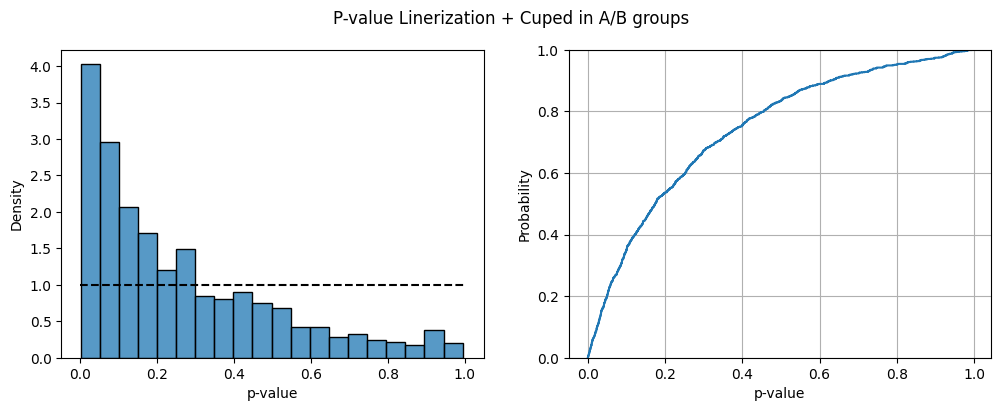

In [ ]:
list_pvalue = []

for _ in tqdm_notebook(range(1000)):
    f_a = choose_random_rows(list(durations_first))
    s_a = choose_random_rows(list(durations_second))
    f_b = choose_random_rows(list(durations_firstbefore))
    s_b = choose_random_rows(list(durations_secondbefore))

    pvalue = cuped_linearization(f_b, f_a, s_b, s_a)

    list_pvalue.append(pvalue)

plot_pvalue_ecdf(list_pvalue, title='P-value Linerization + Cuped in A/B groups')

In [ ]:
pvalue = cuped_linearization(list(durations_firstbefore),
                                   list(durations_first), list(durations_secondbefore),
                                   list(durations_second))
print('Разница значима:', pvalue < 0.05, '\npvalue:', pvalue)

Разница значима: False 
pvalue: 0.06015500416699708


pvalue незначительно подрос. Посмотрим, что мы сделали. Мы к линеаризованным метрикам применили CUPED: вычли информацию о группах до с каким-то коэффициентом. Заметим, что наши метрики до и после нескоррелированы:

In [ ]:
from scipy.stats import pearsonr

f_b, s_b = linearization(list(durations_firstbefore), list(durations_secondbefore))
f_a, s_a = linearization(list(durations_first), list(durations_second))

print(pearsonr(f_b, f_a), pearsonr(s_b, s_a), sep='\n')

PearsonRResult(statistic=-0.03163032095159644, pvalue=0.31767961618805707)
PearsonRResult(statistic=0.005621301473416781, pvalue=0.8590840649956653)


Поэтому получается, что пользы от CUPED нет, более тонко видеть, есть ли статзначимость, мы не стали. Поэтому изменение такое незначительное.

Сонаправленность линеаризованной и ratio метрик мы уже рисовали в прошлом пункте.

### Задача 4. Последовательное тестирование (3 балла)

Сгенерируйте две контрольные выборки и одну тестовую (с эффектом). Проведите последовательные АА-тесты и АБ-тесты по следующей схеме:

1. Попробуйте использовать t-test. Начните с 1 наблюдения в группах и последовательно добавлять по одному в каждую. Проследите, как меняется О1Р, О2Р.

2. Самостоятельно реализуйте **SPRT-тест Вальда** и проделайте ту же процедуру с ним. Что теперь происходит с О1Р и О2Р? Почему?

#### t-test

Проведем отдельно A/A и A/B тесты (вместе проводить не будем, чтобы не думать про множественное тестирование!)

В А/А-тесте мы посчитаем ошибку первого рода, т.е. вероятность отвергнуть верную нулевую гипотезу (в А/А-тесте группы похожие, и когда pvalue < alpha, мы говорим, что разница статзначима, --- но это не так, группы похожи, т.е. совершаем ошибку первого рода).

В А/B-тесте мы посчитаем ошибку второго рода, т.е. принять неверную нулевую гипотезу (в А/B-тесте наши группы гарантированно разные, и когда pvalue >= alpha, мы говорим, что разница нестатзначима, но должно быть наоборот! то есть совершаем ошибку второго рода).

Сделала двумя способами, первый кажется более логичным. Вот первый, тут я добавляю данные и считаю pvalue. Если pvalue оказался ниже/выше (в зависимости от типа ошибки), я останавливаю тестирование --- как в идее последовательного тестирования, когда мы пересекаем порог и прекращаем перебирать. Во втором способе не прекращаю перебирать, просто считаю ошибки первого/второго рода каждый раз.

In [219]:
exp_num = 1000
data_size = 1000
alpha = 0.05

o1p = np.array([0 for _ in range(data_size)])

for _ in range(exp_num):
  aa_1 = np.random.normal(loc=0, scale=100, size=data_size)
  aa_2 = np.random.normal(loc=0, scale=100, size=data_size)

  for size in range(data_size):
    a_1 = aa_1[:size]
    a_2 = aa_2[:size]

    pvalue = stats.ttest_ind(a_1, a_2).pvalue

    if pvalue < alpha:
      error_1 = np.array([0 if s < size else 1 for s in range(data_size)])
      o1p += error_1
      break

In [235]:
exp_num = 1000
data_size = 1000
alpha = 0.05

o2p = np.array([0 for _ in range(data_size)])

for _ in range(exp_num):
  aa_1 = np.random.normal(loc=0, scale=100, size=data_size)
  aa_2 = np.random.normal(loc=100, scale=100, size=data_size)

  for size in range(data_size):
    a_1 = aa_1[:size]
    a_2 = aa_2[:size]

    pvalue = stats.ttest_ind(a_1, a_2).pvalue

    if pvalue >= alpha:
      error_2 = np.array([0 if s < size else 1 for s in range(data_size)])
      o2p += error_2
      break

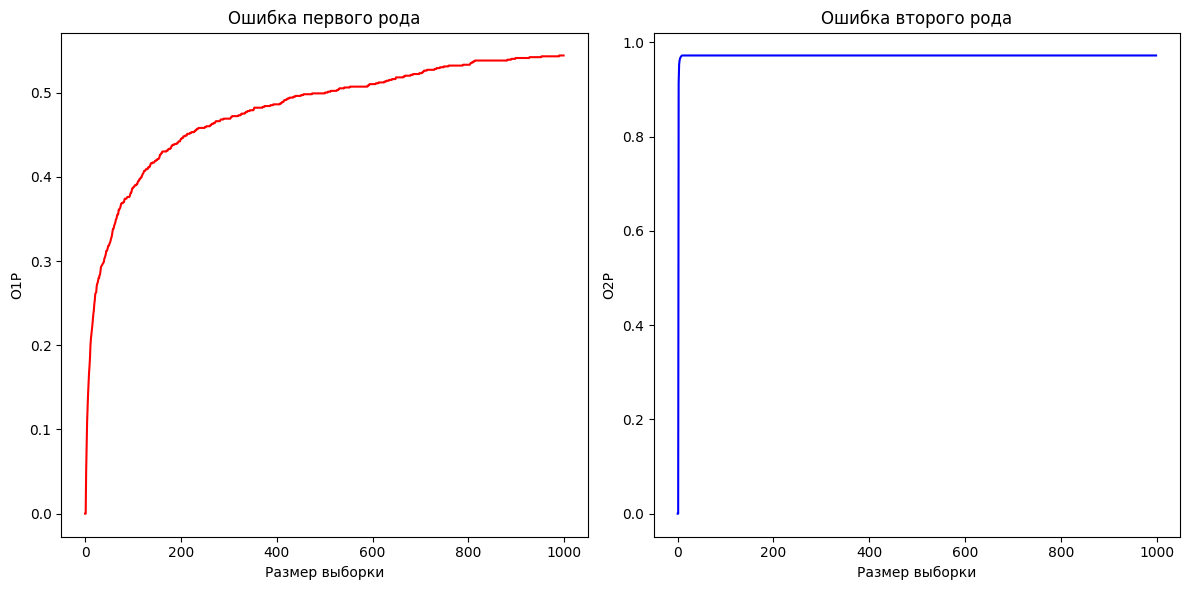

In [237]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(o1p / exp_num, color='r')
plt.xlabel('Размер выборки')
plt.ylabel('O1P')
plt.title('Ошибка первого рода')

plt.subplot(1, 2, 2)
plt.plot(o2p / exp_num, color='b')
plt.xlabel('Размер выборки')
plt.ylabel('O2P')
plt.title('Ошибка второго рода')

plt.tight_layout()
plt.show()

Мы видим, что в случае ошибки второго рода мы практически сразу принимаем неверную нулевую гипотезу (говорим, что различия разных групп нестатзначимы), и прекращаем тестирование. Решение через подсчет pvalue на каждом расширении выборки:

In [ ]:
o1p = []

exp_num = 1000
data_size = 1000
alpha = 0.05

aa_1 = np.random.normal(loc=0, scale=100, size=(data_size, exp_num))
aa_2 = np.random.normal(loc=0, scale=100, size=(data_size, exp_num))

for size in tqdm_notebook(range(1, data_size)):
  a_1 = aa_1[:size]
  a_2 = aa_2[:size]

  pvalues = stats.ttest_ind(a_1, a_2).pvalue

  error_1 = (pvalues < alpha).mean()
  o1p.append(error_1)

o2p = []

ab_1 = np.random.normal(loc=0, scale=100, size=(data_size, exp_num))
ab_2 = np.random.normal(loc=20, scale=100, size=(data_size, exp_num))

for size in tqdm_notebook(list(range(1, data_size))):
    a = ab_1[:size]
    b = ab_2[:size]

    pvalues = stats.ttest_ind(a, b).pvalue

    error_2 = (pvalues > alpha).mean()
    o2p.append(error_2)

  0%|          | 0/999 [00:00<?, ?it/s]

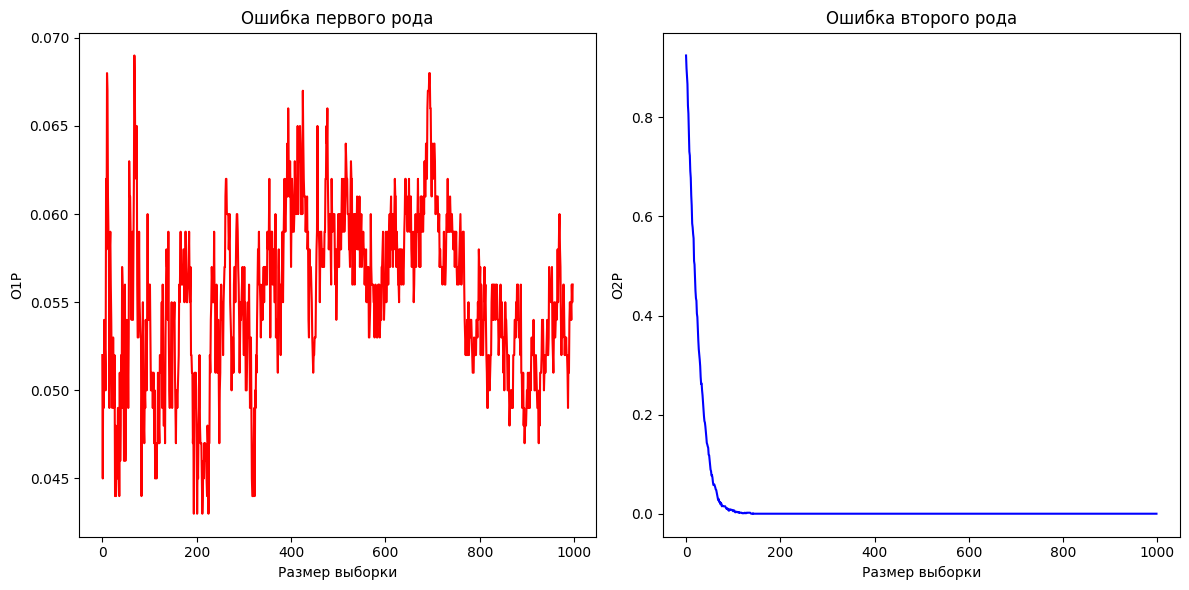

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(plt.plot(o1p / 1000), color='r')
plt.xlabel('Размер выборки')
plt.ylabel('O1P')
plt.title('Ошибка первого рода')

plt.subplot(1, 2, 2)
plt.plot(o2p/100, color='b')
plt.xlabel('Размер выборки')
plt.ylabel('O2P')
plt.title('Ошибка второго рода')

plt.tight_layout()
plt.show()

Что мы видим? Ничего хорошего применение последовательного тестирования к тесту, для этого не предназначенного, нам не дало. По ошибке второго рода видим, что неправильно было выключать тест сразу, как мы пробили простой порог: дальше ошибка уменьшится, а мы уже согласились на очень большую!
А значение ошибки первого рода постоянно колеблется и может пробивать пороги много раз, не означая, что мы нашли лучшее решение. Пробуем более сложные методы.

#### SPRT-тест

Теперь проведем SPRT-тест Вальда. Кратко запишем его суть.

Пусть есть две точечные гипотезы:

$H_0: \theta = \theta_0 \\ H_1: \theta = \theta_1$

Пусть $f_{0m}$ -- функция правдоподобия $H_0$ для выборки размера $m$, $f_{1m}$ --- аналогично для $H_1$.

Если верна $H_1$, то отношение правдоподобия $\frac{f_{1m}}{f_{0m}}$ больше 1. Если верна $H_0$, то меньше 1. Теорема, доказанная Вальдом, такая:

$\forall \alpha \in (0, 1), \beta \in (0, 1)$ сравниваем $H_0$ и $H_1$ на уровне значимости $\alpha$ и с мощностью $1 - \beta$ таким алгоритмом:

for $m = 0, 1, ...$:

$\bullet$ Если $\frac{f_{1m}}{f_{0m}} \geq \frac{1 - \beta}{\alpha}$, останавливаемся и отвергаем $H_0$.

$\bullet$ Если $\frac{f_{1m}}{f_{0m}} \leq \frac{\beta}{1 - \alpha}$, останавливаемся и не отвергаем $H_0$.

$\bullet$ Если $\frac{1 - \beta}{\alpha} \leq \frac{f_{1m}}{f_{0m}} \leq \frac{\beta}{1 - \alpha}$, продолжаем алгоритм.

Разобралась по [этому](https://ucb-stat-159-s21.github.io/site/Notes/sprt.html) материалу.

Перепишем алгоритм так, чтобы на каждой итерации добавлять новую информацию, а не пересчитывать заново, получится вот так: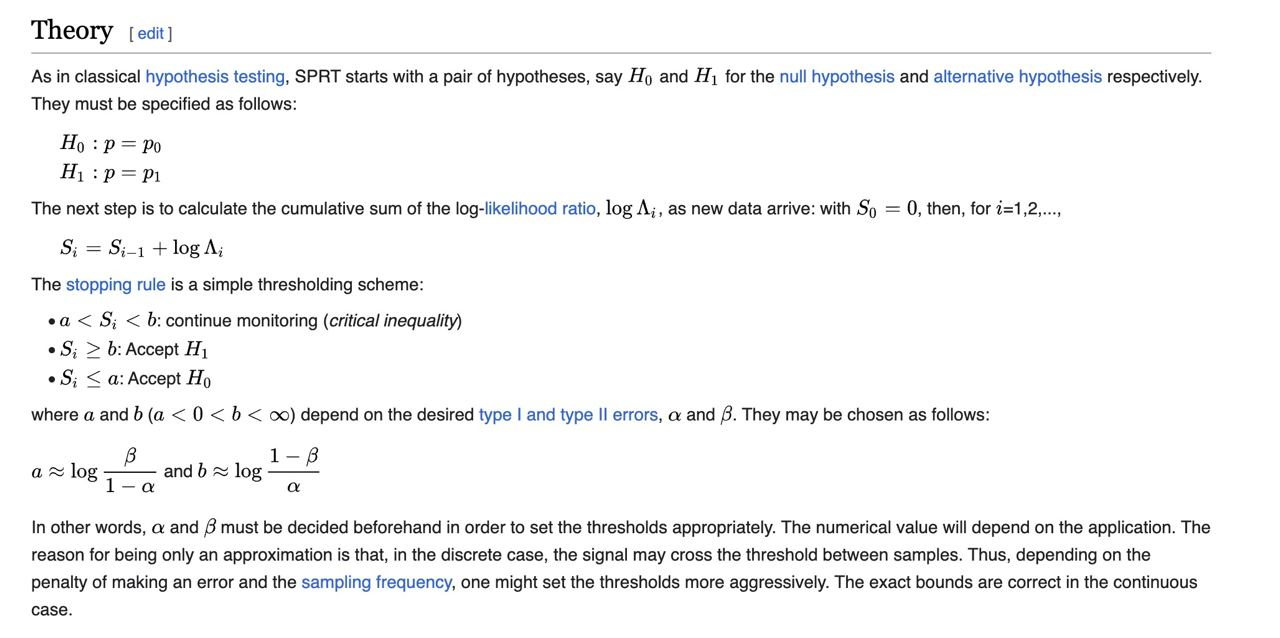

Хотим провести тест, чтобы узнать, равны ли средние наших выборок $X$ и $Y$. Для этого мы можем проверить гипотезу, что матожидание $X \cup Y$ равно матожиданию $X$ (хотела изначально проверить для разности, но не получилось, видимо, из-за того, что что-то происходит с функцией распределения при вычитании).

Пойдем по простому пути и будем тестировать экспоненциальные распределения, т.к. для них все [посчитано](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test) в википедии!

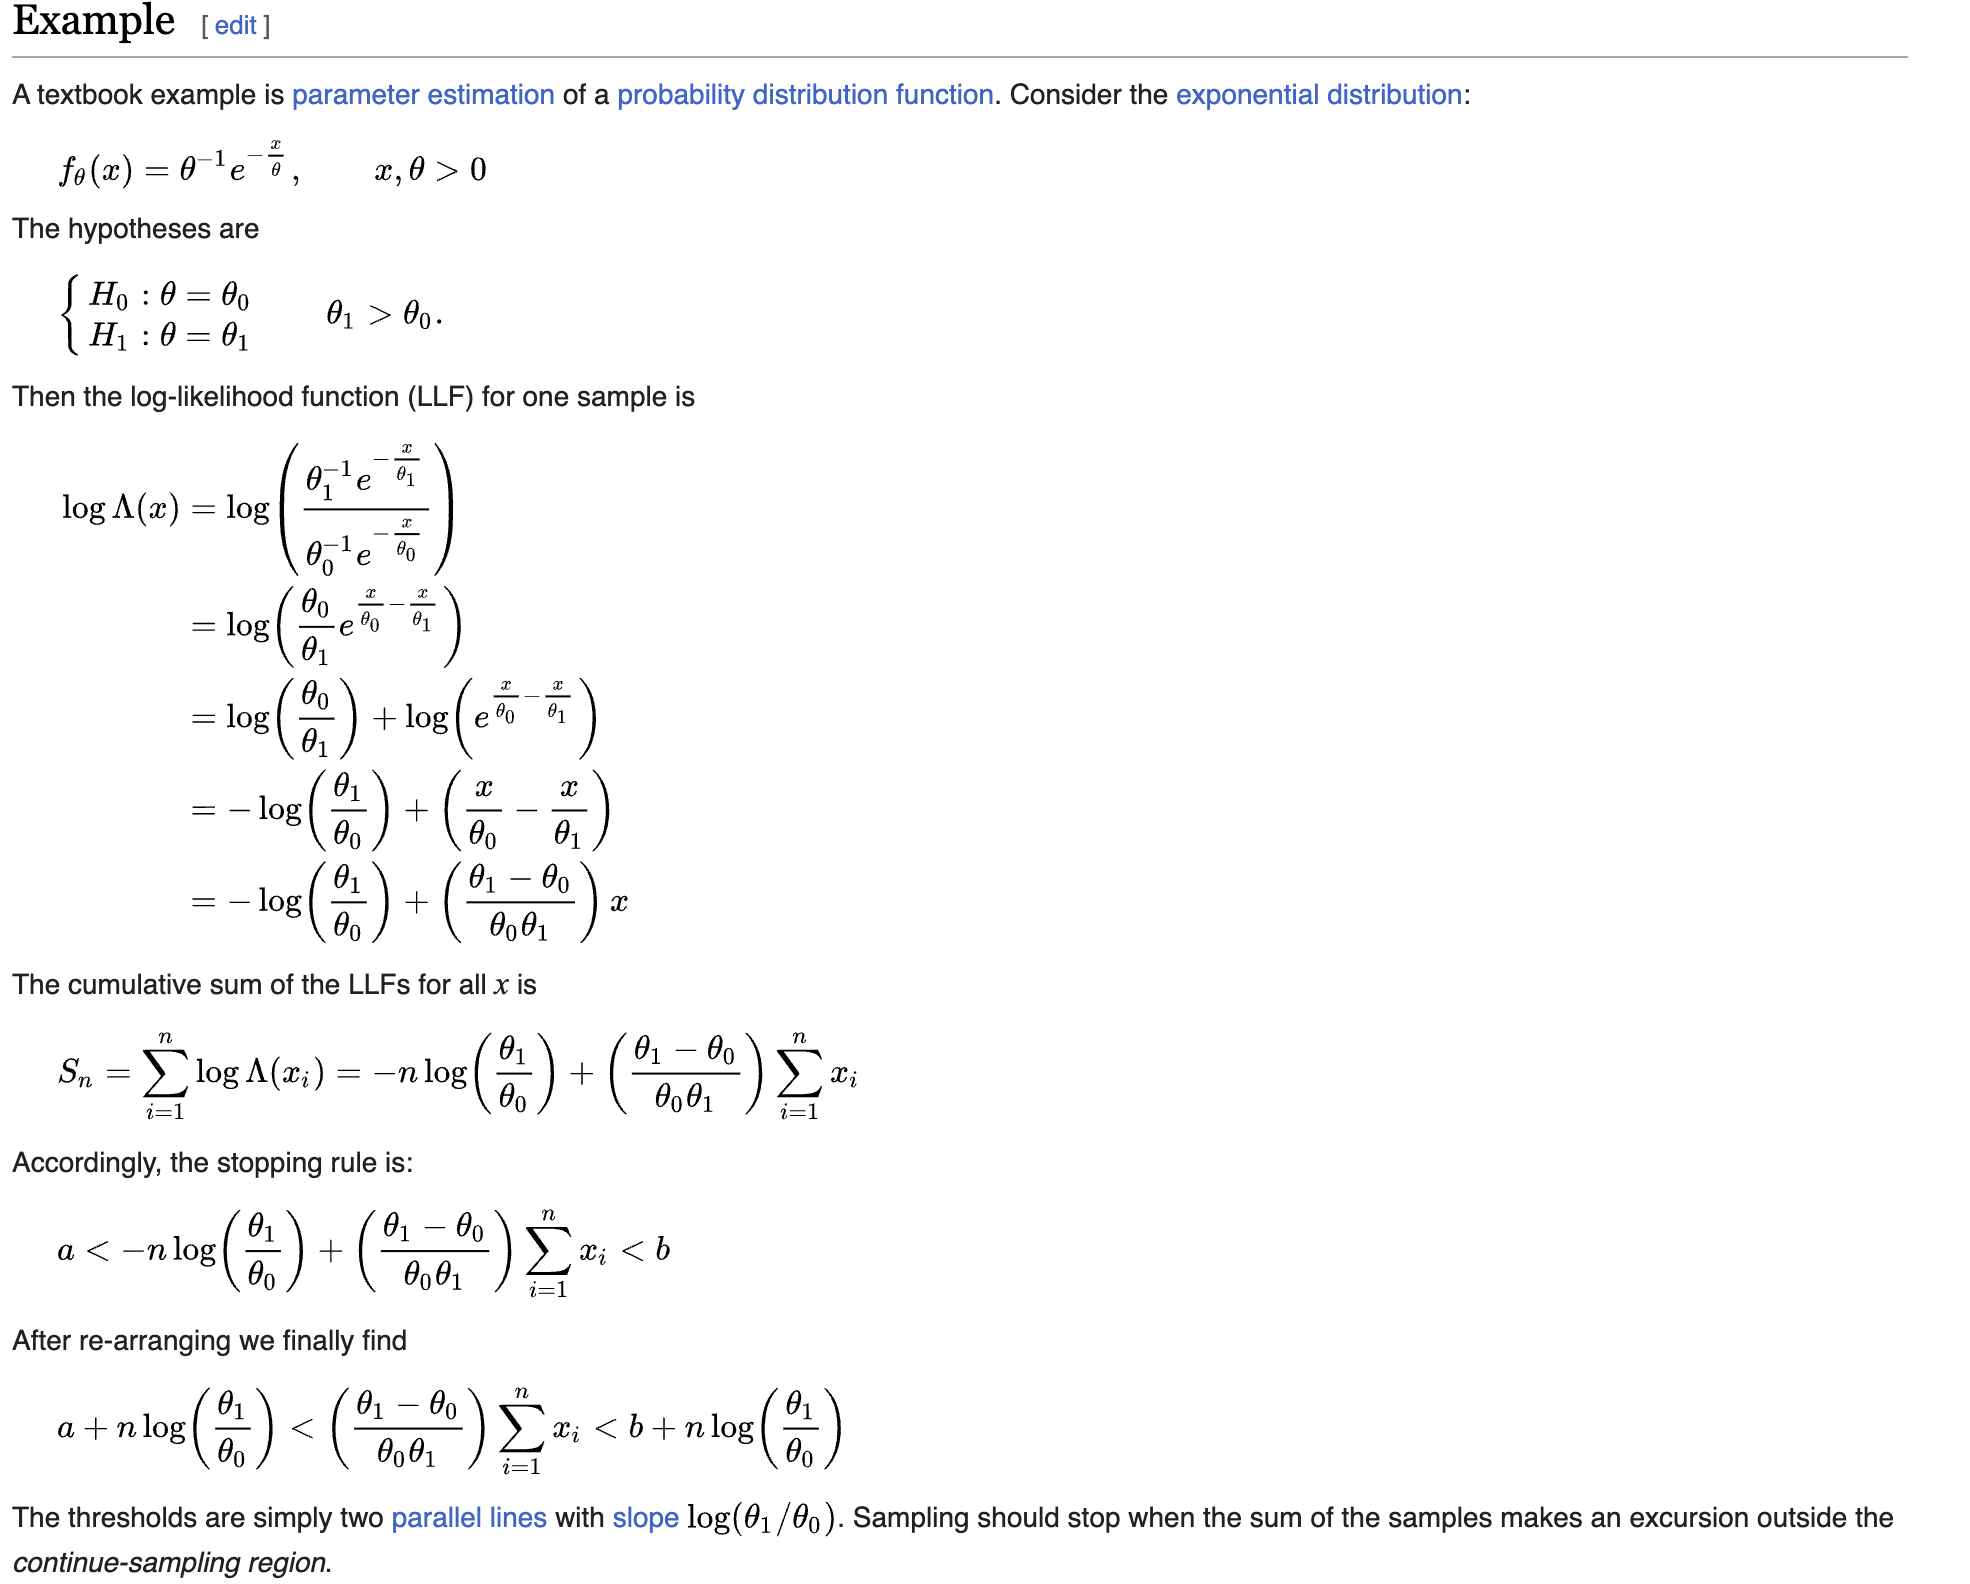

Снова проведем сначала А/А, потом А/B, на всякий случай чтобы не думать про множественное тестирование!

In [209]:
data_size = 1000
num_exp = 1000

theta_0 = 1
theta_1 = 1.45

beta = 0.2
alpha = 0.05
treshold_max = np.log(beta/(1 - alpha))
treshold_min = np.log((1 - beta)/alpha)

o1p = np.array([0 for _ in range(data_size)])
for _ in range(num_exp):
  aa_1 = stats.expon(scale=1).rvs(size=data_size//2)
  aa_2 = stats.expon(scale=1).rvs(size=data_size//2)
  test_data = np.append(aa_1, aa_2)
  np.random.shuffle(test_data)  # чтобы код не кушол сначала первый массив, а потом второй

  S = 0
  for m in range(1, data_size):
    new_data = test_data[m]
    S += (-np.log(theta_1 / theta_0) + (theta_1 - theta_0)/(theta_0 * theta_1) * new_data)

    if S >= treshold_min:
      o1p += np.array([0 if i < m else 1 for i in range(len(test_data))])
      break
    elif S <= treshold_max:
      break
    # cлучай, когда данные закончились, а никакой порог не пробит, будем считать выбросом и не учитывать

In [207]:
data_size = 1000
num_exp = 1000

theta_0 = 1
theta_1 = 1.25

beta = 0.2
alpha = 0.05
treshold_max = np.log(beta/(1 - alpha))
treshold_min = np.log((1 - beta)/alpha)

o2p = np.array([0 for _ in range(data_size)])
for _ in range(num_exp):
  aa_1 = stats.expon(scale=1).rvs(size=data_size//2)
  aa_2 = stats.expon(scale=1.5).rvs(size=data_size//2)
  test_data = np.append(aa_1, aa_2)
  np.random.shuffle(test_data)

  S = 0
  for m in range(1, data_size):
    new_data = test_data[m]
    S += (-np.log(theta_1 / theta_0) + (theta_1 - theta_0)/(theta_0 * theta_1) * new_data)

    if S >= treshold_min:
      break
    elif S <= treshold_max:
      o2p += np.array([0 if i < m else 1 for i in range(len(test_data))])
      break
    # cлучай, когда данные закончились, а никакой порог не пробит, будем считать выбросом и не учитывать

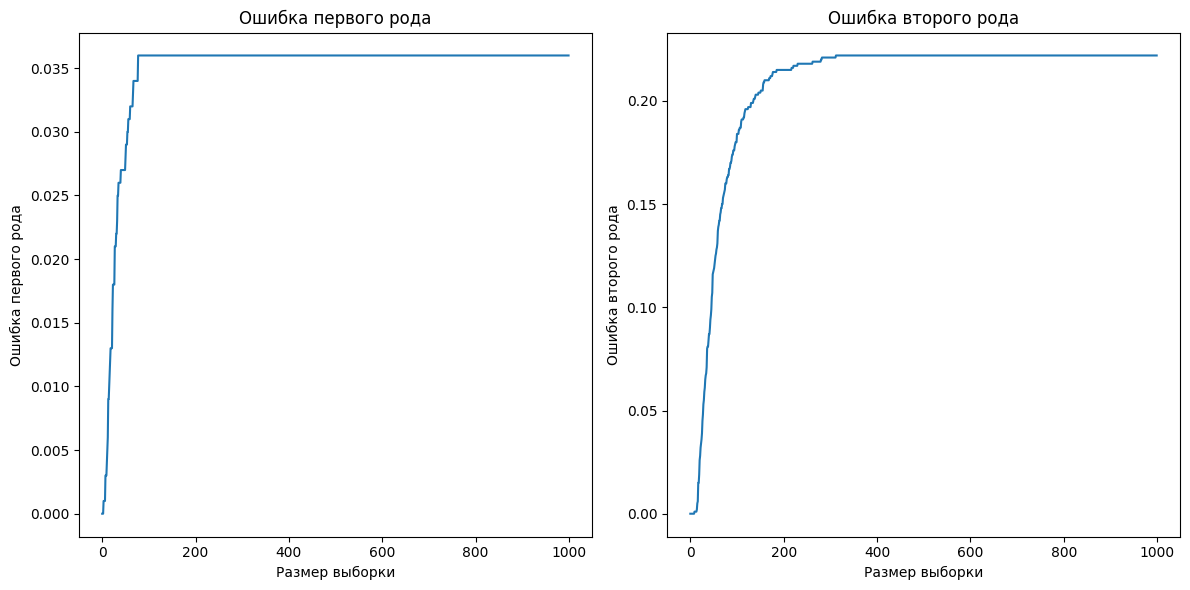

In [211]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.array(o1p) / 1000)
plt.title('Ошибка первого рода')
plt.xlabel('Размер выборки')
plt.ylabel('Ошибка первого рода')

plt.subplot(1, 2, 2)
plt.plot(np.array(o2p)/1000)
plt.title('Ошибка второго рода')
plt.xlabel('Размер выборки')
plt.ylabel('Ошибка второго рода')

plt.tight_layout()
plt.show()

Прекрасно! Видим, что ошибки первого и второго рода в какой-то момент выходят на плато, а также не превосходят заданных уровней, --- как мы и ожидали.

Какой вывод мы можем сделать? Как видим, в первом случае применение последовательного тестирования к тесту, не предназначенного для этого, не ведет ни к чему хорошему (а только к повышению ошибки первого рода), поэтому так делать нельзя. Второй же метод сработал, как мы ожидали.